# How do we know the observed expression differences are real and not random noise?

In [1]:
import pandas as pd

df = pd.read_csv("breastcancer.csv")

# Clean column names & type
df.columns = df.columns.str.strip()
df['type'] = df['type'].str.strip().str.lower()

# Create basal_status
df['basal_status'] = (df['type'] == 'basal').astype(int)
df['basal_status'].value_counts()


,count
basal_status,
0,110
1,41


In [2]:
gene_cols = df.columns.drop(['type', 'basal_status'])

basal_df = df[df['basal_status'] == 1]
nonbasal_df = df[df['basal_status'] == 0]


In [3]:
mean_diffs = []

for gene in gene_cols:
    diff = basal_df[gene].mean() - nonbasal_df[gene].mean()
    mean_diffs.append([gene, diff])

mean_df = pd.DataFrame(mean_diffs, columns=['Gene', 'Mean_Difference'])
mean_df['Abs_Mean_Diff'] = mean_df['Mean_Difference'].abs()
mean_df = mean_df.sort_values('Abs_Mean_Diff', ascending=False)


In [4]:
from scipy.stats import ttest_ind

top_genes = mean_df.head(200)['Gene']

stats = []

for gene in top_genes:
    t_stat, p_val = ttest_ind(
        basal_df[gene],
        nonbasal_df[gene],
        equal_var=False
    )
    stats.append([gene, p_val])

stats_df = pd.DataFrame(stats, columns=['Gene', 'P_Value'])


In [5]:
from statsmodels.stats.multitest import multipletests

final_df = mean_df.merge(stats_df, on='Gene')
final_df['FDR'] = multipletests(final_df['P_Value'], method='fdr_bh')[1]

final_df = final_df.sort_values('FDR')
final_df.head(10)


,Gene,Mean_Difference,Abs_Mean_Diff,P_Value,FDR
47,226961_at,-2.839093,2.839093,1.137676e-32,2.275352e-30
108,235046_at,-2.278558,2.278558,5.176182e-31,5.176182e-29
9,229150_at,-3.841995,3.841995,1.348478e-29,8.989851e-28
41,224428_s_at,2.881295,2.881295,8.781905e-29,2.927302e-27
103,205376_at,-2.321743,2.321743,8.525250e-29,2.927302e-27
10,218211_s_at,-3.804738,3.804738,8.548010e-29,2.927302e-27
53,211110_s_at,-2.763311,2.763311,1.393413e-28,3.981180e-27
82,211621_at,-2.462258,2.462258,9.735886e-28,2.433972e-26
75,228302_x_at,-2.526001,2.526001,2.906065e-27,6.457922e-26
30,226197_at,-3.031836,3.031836,4.011363e-26,8.022725e-25


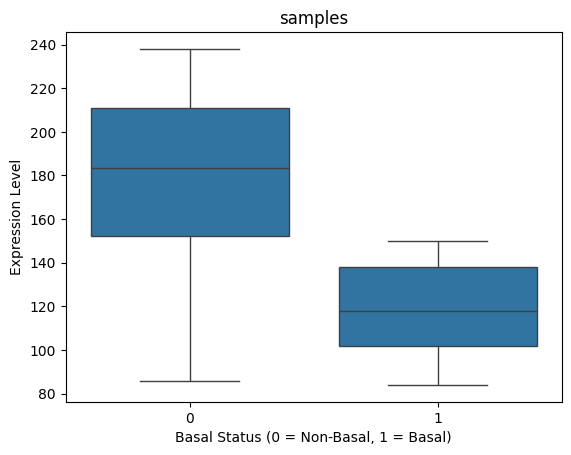

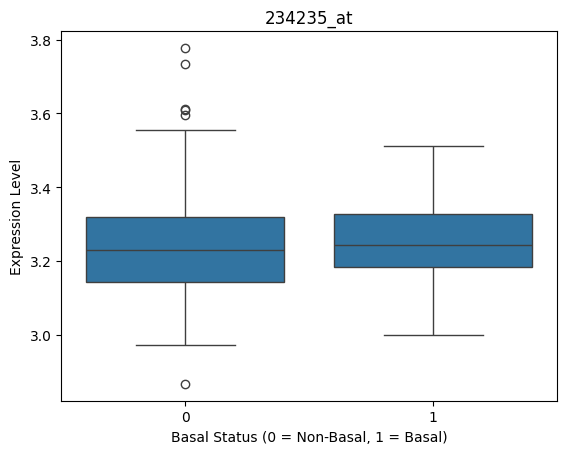

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

top_up = mean_df.iloc[0]['Gene']
top_down = mean_df.iloc[-1]['Gene']

for gene in [top_up, top_down]:
    sns.boxplot(x=df['basal_status'], y=df[gene])
    plt.title(gene)
    plt.xlabel('Basal Status (0 = Non-Basal, 1 = Basal)')
    plt.ylabel('Expression Level')
    plt.show()


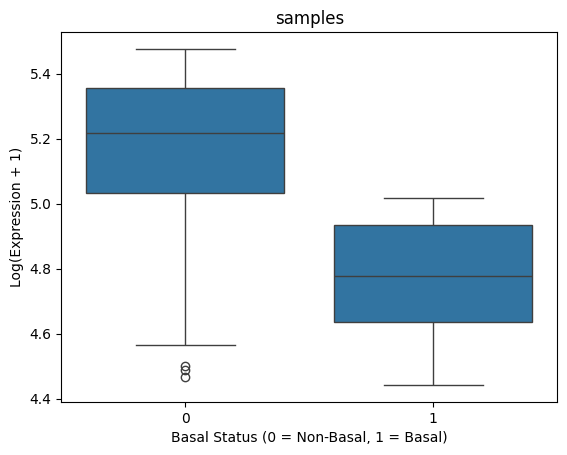

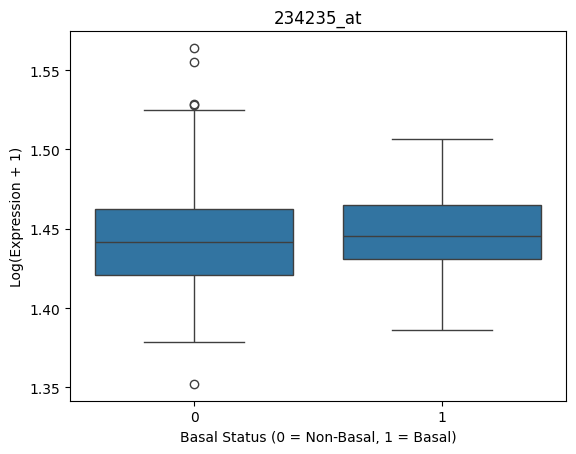

In [7]:
import numpy as np

for gene in [top_up, top_down]:
    sns.boxplot(
        x=df['basal_status'],
        y=np.log1p(df[gene])  # log-transform to shrink scale
    )
    plt.title(gene)
    plt.xlabel('Basal Status (0 = Non-Basal, 1 = Basal)')
    plt.ylabel('Log(Expression + 1)')
    plt.show()


Probe 1:

The first probe is upregulated in Non-Basal breast cancer compared to Basal. The median expression is higher in Non-Basal samples, indicating that this probe is likely associated with Non-Basal breast cancer. Extreme values are minimal and do not significantly affect interpretation. The probe shows relatively high expression within Non-Basal samples (~5.6), suggesting it is biologically relevant in Non-Basal types.

Probe 234235_at:

Probe 234235_at is slightly upregulated in Basal samples compared to Non-Basal, but both groups have generally low expression (~1.46). This indicates that, despite a small relative difference, the probe likely has no meaningful association with breast cancer. Outliers exist but are minor and do not affect overall interpretation.

Differential expression analysis identified multiple probes with significant expression differences between Basal and Non-Basal breast cancer samples. Genes were first ranked by absolute mean difference to prioritize biologically meaningful effects. Welch’s t-test was then applied to top-ranked genes to assess statistical significance, accounting for unequal sample sizes and variances. False discovery rate correction was used to control for multiple testing. Box plot visualization confirmed that statistically significant genes also exhibited clear median separation between groups, supporting subtype-specific transcriptional differences.

Several limitations should be considered when interpreting these results. The unequal sample sizes between Basal and Non-Basal groups may affect variance estimates and statistical power. Additionally, probe-based microarray measurements may not fully reflect functional gene activity or protein expression. The prioritization of genes by mean difference may exclude subtle but biologically meaningful expression changes. Furthermore, low expression does not necessarily imply lack of biological relevance. Finally, this analysis identifies associations rather than causal relationships, and experimental validation would be required to confirm functional significance.